# SPACEc: Cellular Neighborhood Analysis

## Set up environment

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import time
import sys
import os
import warnings
warnings.filterwarnings('ignore')

data_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/' # where the data is stored
code_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/pipeline_test_112023/src' # current where the code is stored, this will be replaced by pip install soon
output_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/demo_data/output_112023/' #where you want to store the output

if not os.path.exists(output_dir): # check if output path exist - if not generate the path
    os.makedirs(output_dir)
    
sys.path.append(code_dir) 
from helperfunctions_hf import * # Helper functions - used by other functions to execute steps like table formatting etc. KEY: hf
from preprocessing_pp import * # Preprocessing functions - to normalize and prepare data for further analysis KEY: pp
from tools_tl import * # tools - perform calculation on the data KEY: tl
from plot_pl import * # plotting functions - used to visualize results KEY: pl

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
# Loading the denoise/filtered anndata from notebook 3 [cell type or cluster annotation is necessary for the step]
adata = sc.read(output_dir + 'adata_nn_demo_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 48776 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition', 'leiden_0.4', 'leiden_0.4_subcluster_0', 'leiden_0.4_subcluster_3', 'leiden_0.4_subcluster_4', 'celltype', 'leiden_0.4_subcluster_2', 'leiden_0.4_subcluster_11', 'leiden_0.4_subcluster_0sub', 'celltype_fine'
    uns: 'celltype_colors', 'celltype_fine_colors', 'dendrogram_leiden_0.4', 'dendrogram_leiden_0.4_subcluster_4', 'leiden', 'leiden_0.4_colors', 'leiden_0.4_subcluster_0sub_colors', 'leiden_0.4_subcluster_4_colors', 'neighbors', 'umap', 'unique_region_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

# 4.1 Compute for Cellular Neighborhoods

In [3]:
# compute for CNs
# tune k and n_neighborhoods to obtain the best result
adata = tl_neighborhood_analysis_ad(adata, 
                            unique_region = "unique_region", 
                            cluster_col = "celltype_fine", 
                            X = 'x', Y = 'y',
                            k = 20, # k nearest neighbors
                            n_neighborhoods = 6, #number of CNs
                            elbow = False)

Starting: 2/2 : reg001
Finishing: 2/2 : reg001 0.1275038719177246 0.12755203247070312
Starting: 1/2 : reg010
Finishing: 1/2 : reg010 0.08853983879089355 0.21633601188659668


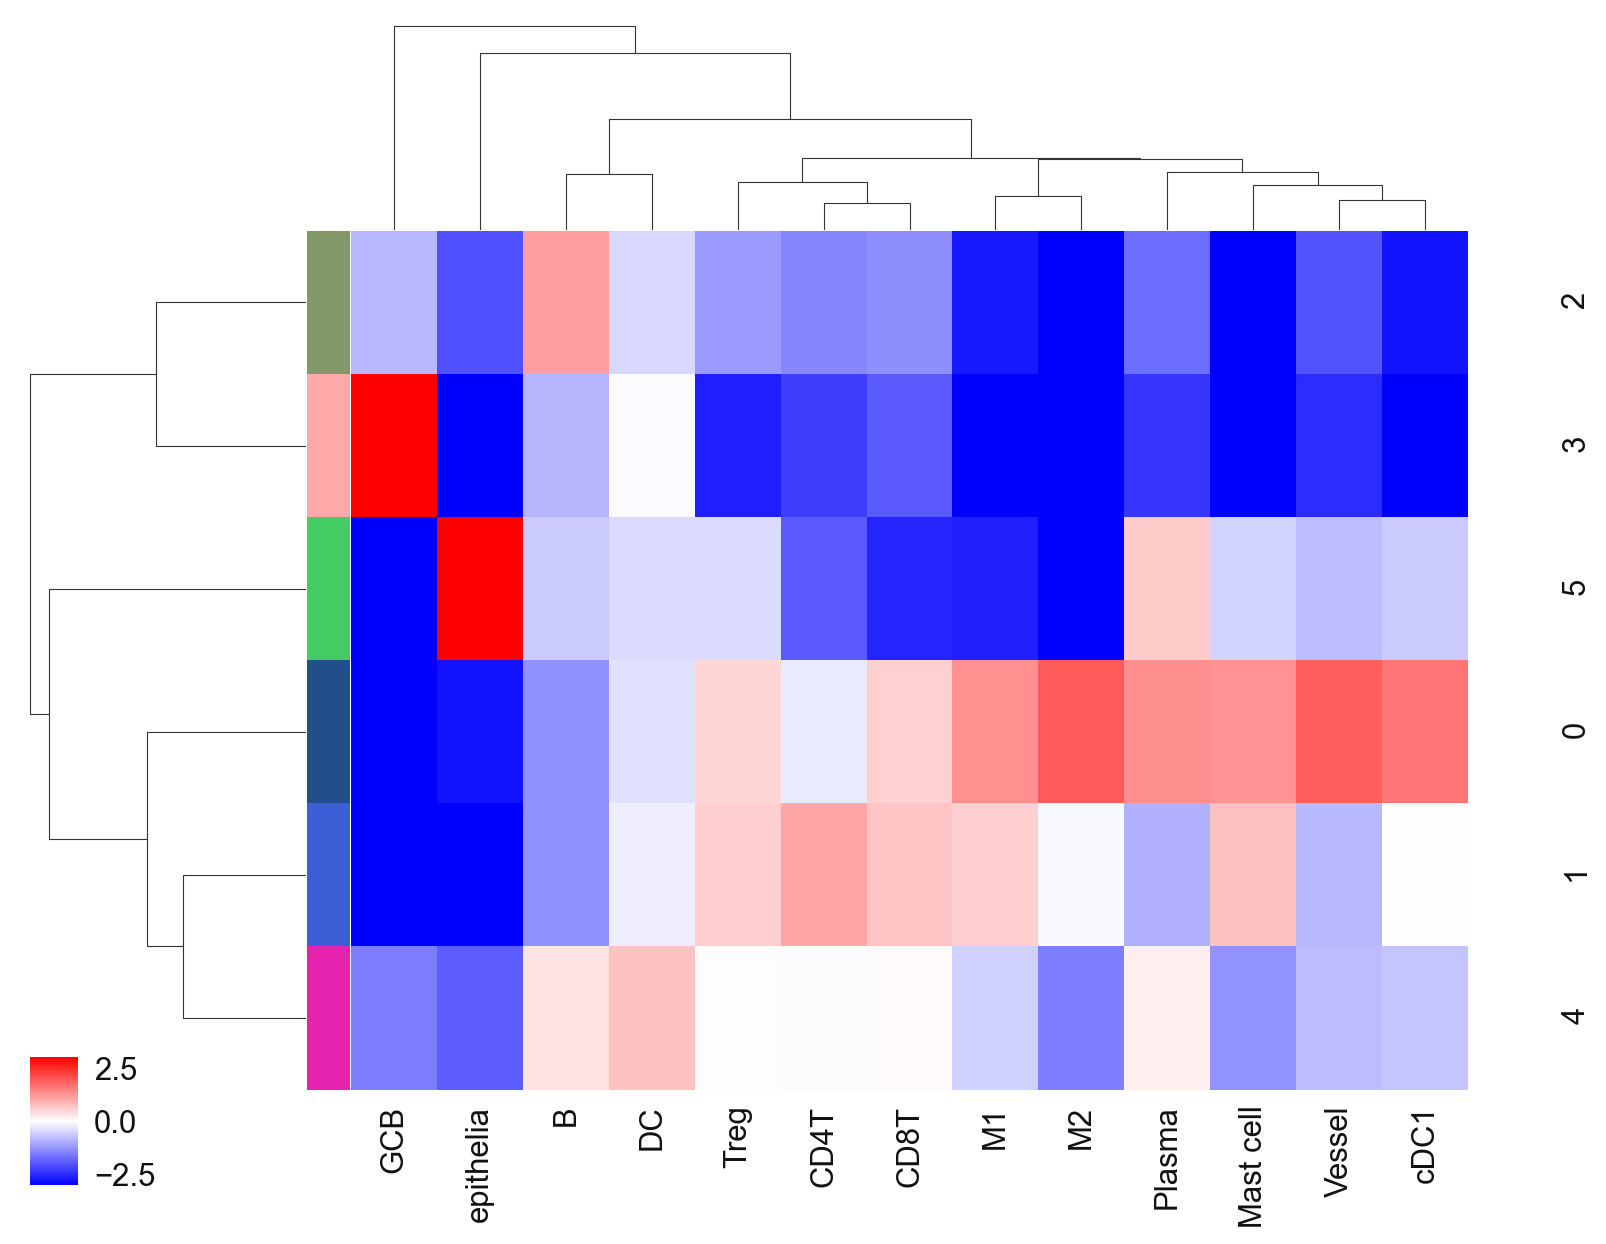

In [4]:
# to better visualize the CN, we choose a CN palette
# but if you set palette = None in the following function, it will randomly generate a palette for you
cn_palette = {0: '#204F89',
 1: '#3C5FD7',
 2: '#829868',
 3: '#FDA9AA',
 4: '#E623B1',
 5: '#44CB63'}

# plot CN to see what cell types are enriched per CN so that we can annotate them better
pl_CN_exp_heatmap_ad(adata, 
                     cluster_col = "celltype_fine",
                     cn_col = "CN_k20_n6",
                     palette=cn_palette,
                     figsize=(10,8),
                     savefig = False,
                     output_dir = output_dir,
                     rand_seed = 1
                    )

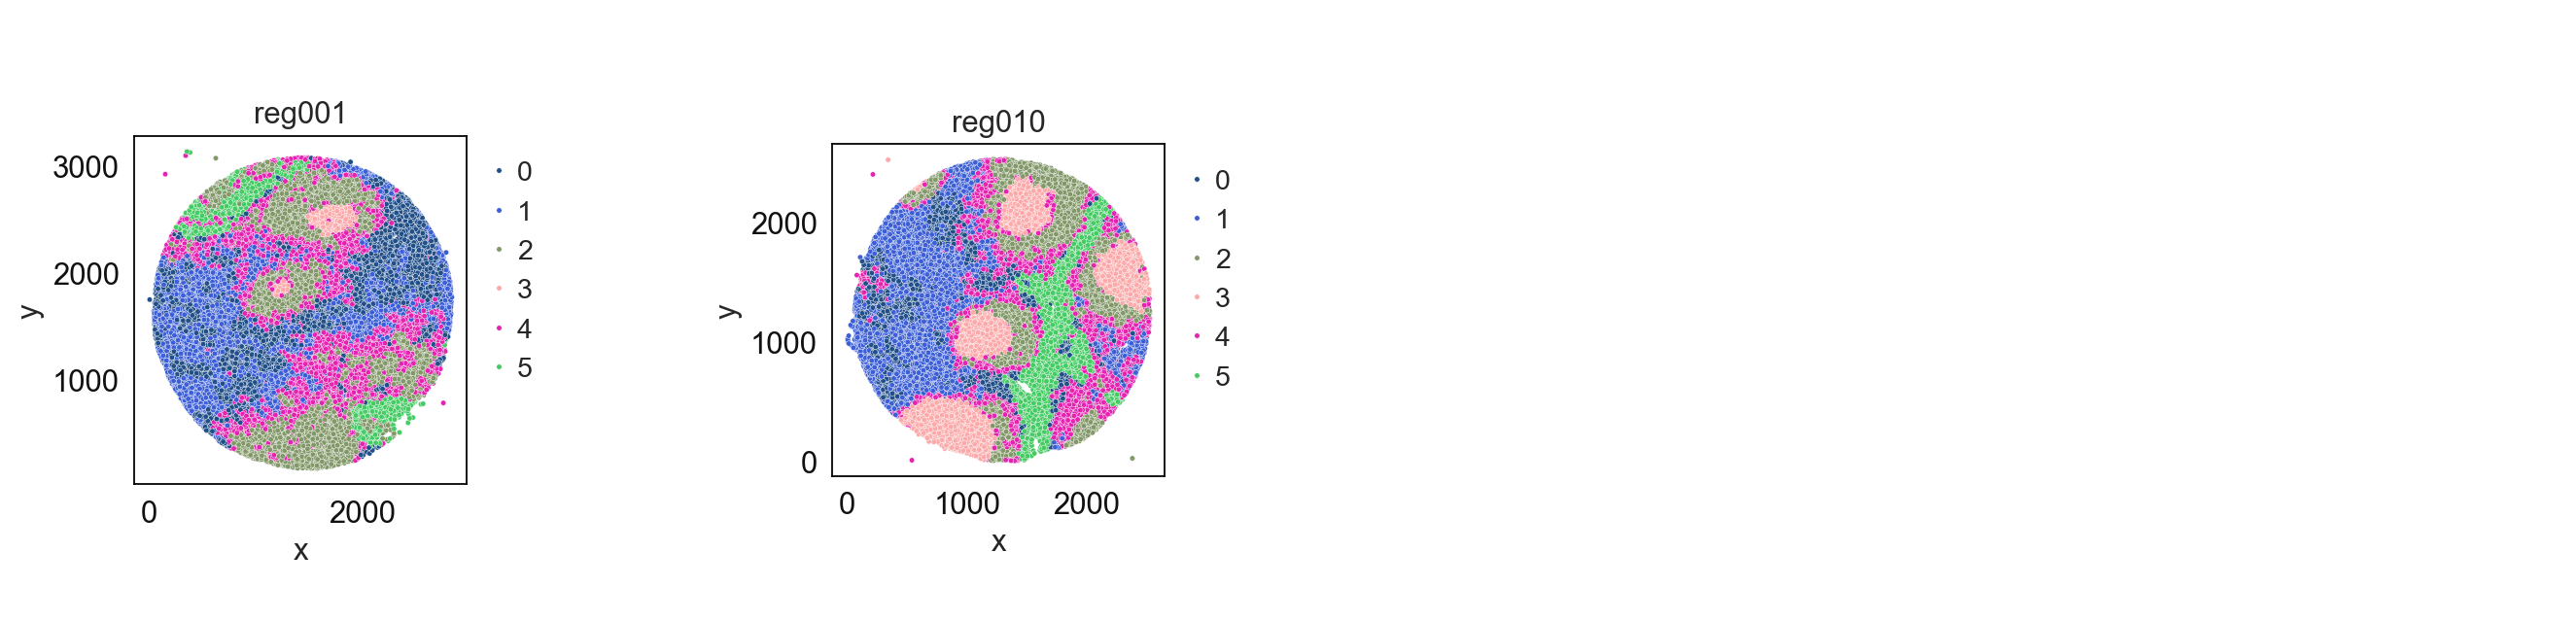

In [5]:
# plot the CN in the spatial coordinates, using the same color palette
pl_catplot_ad(adata, 
              color = "CN_k20_n6", 
              unique_region = "unique_region",
              X='x', Y='y',
              palette= cn_palette, 
              savefig=False,
              output_dir=output_dir,
             )

In [6]:
# Define neighborhood annotation for every cluster ID
neighborhood_annotation = {
    0: 'Immune Priming Zone',
    1: 'Parafollicular T cell Zone',
    2: 'Marginal Zone',
    3: 'Germinal center',
    4: 'Marginal Zone B-DC Enriched',# we dont have the DC markers to separate the inner pink from the outer pink; but they are both encountering immature B cells
    5: "Epithelium", 
}

adata.obs['CN_k20_n6_annot'] = (
    adata.obs['CN_k20_n6']
    .map(neighborhood_annotation)
    .astype('category')
)

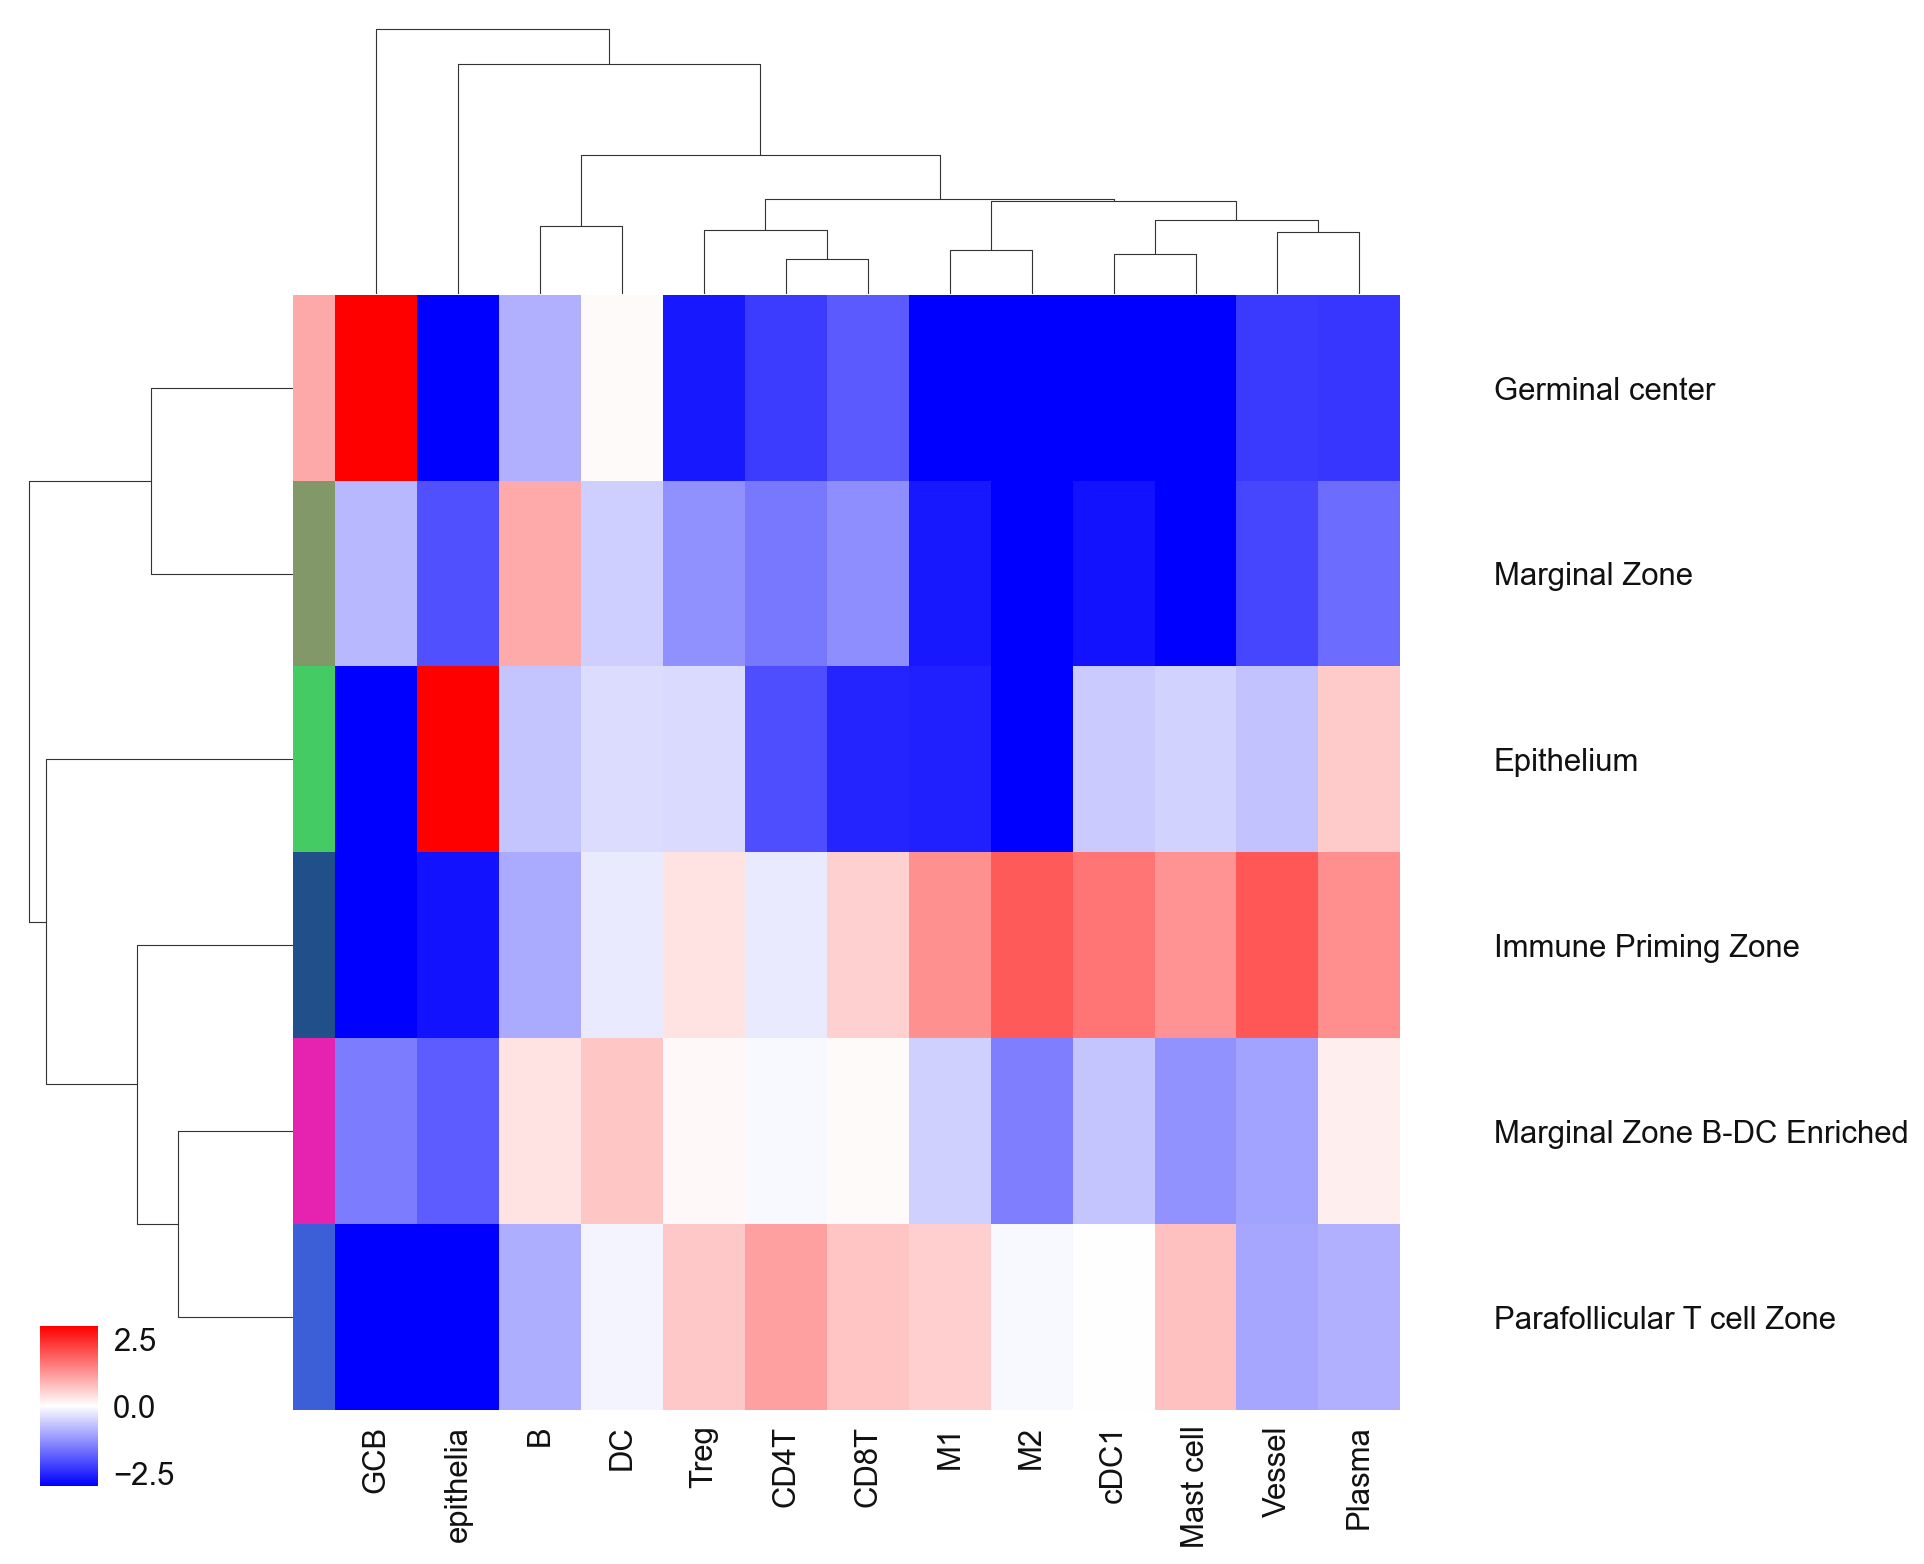

In [7]:
# match the color of the annotated CN to the original CN
cn_annt_palette = {neighborhood_annotation[key]: value for key, value in cn_palette.items()}

# replotting with CN annotation
pl_CN_exp_heatmap_ad(adata, 
                      cluster_col = "celltype", 
                      cn_col = "CN_k20_n6_annot",
                      palette = cn_annt_palette, #if None, there is randomly generated in the code 
                      savefig=True,
                      figsize=(12,10),
                      output_fname = "",
                      output_dir = output_dir,
                      )

In [8]:
adata.write_h5ad(output_dir + 'adata_nn_demo_annotated_cn.h5ad')

## 4.2 Spatial context maps
To plot the spatial context between cellular neighborhoods or communities spatial context maps are a useful visualization. The analysis uses a similar sliding window approach as used for the detection of CNs/Communities but takes these broader groups as input. The resulting vectors are used to analyze which CNs/Communities tend to form interfaces. These interfaces are shown in the graph. Colored squares show single CNs or combinations of them, edges connect parent nodes with daughter nodes. The black circles indicate the abundance of cells falling into these spatial groups. 

In [9]:
# We will look at the spatial context maps sepataely for each condition
adata_tonsil = adata[adata.obs['condition'] == 'tonsil']
adata_tonsillitis = adata[adata.obs['condition'] == 'tonsillitis']

#### tonsil

Starting: 1/1 : 1
Finishing: 1/1 : 1 0.2925238609313965 0.29253196716308594
8 0.02429836127330942


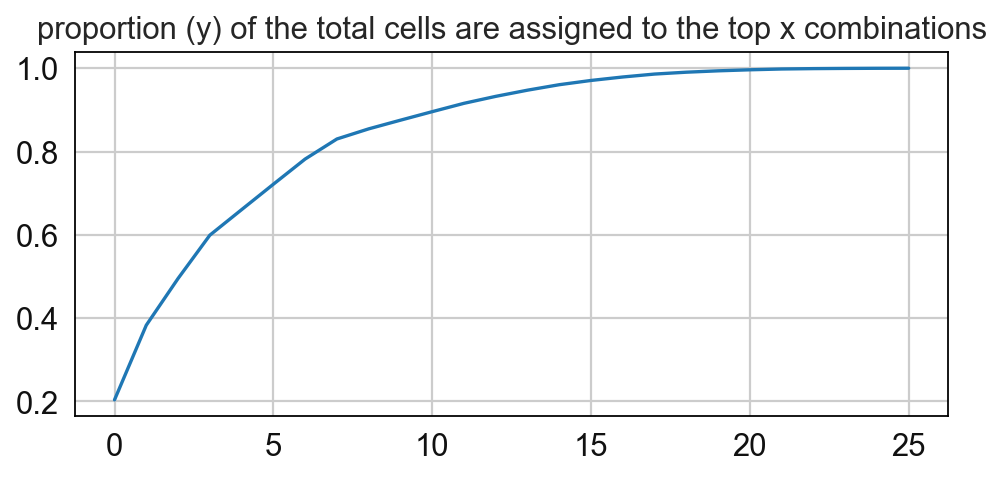

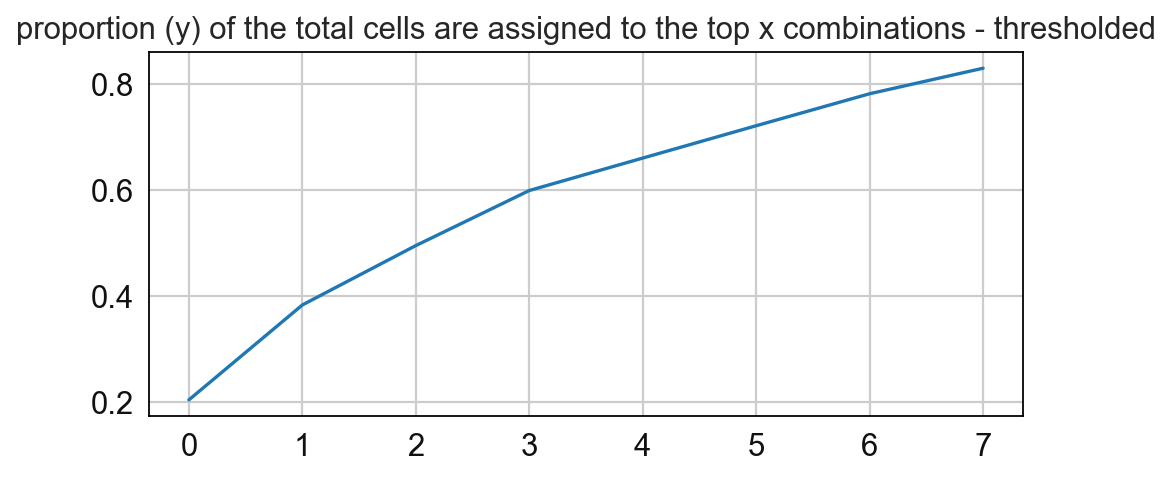

In [10]:
cnmap_dict_tonsil = tl_CNmap_ad(adata = adata_tonsil, # adata object
                                     cn_col = "CN_k20_n6",# column with CNs
                                     palette = None, # color dictionary
                                     unique_region = 'region_num',# column with unique regions
                                     k = 70, # number of neighbors
                                     X='x', Y='y',  # coordinates
                                     threshold = 0.85, # threshold for percentage of cells in CN
                                     per_keep_thres = 0.85,) # threshold for percentage of cells in CN

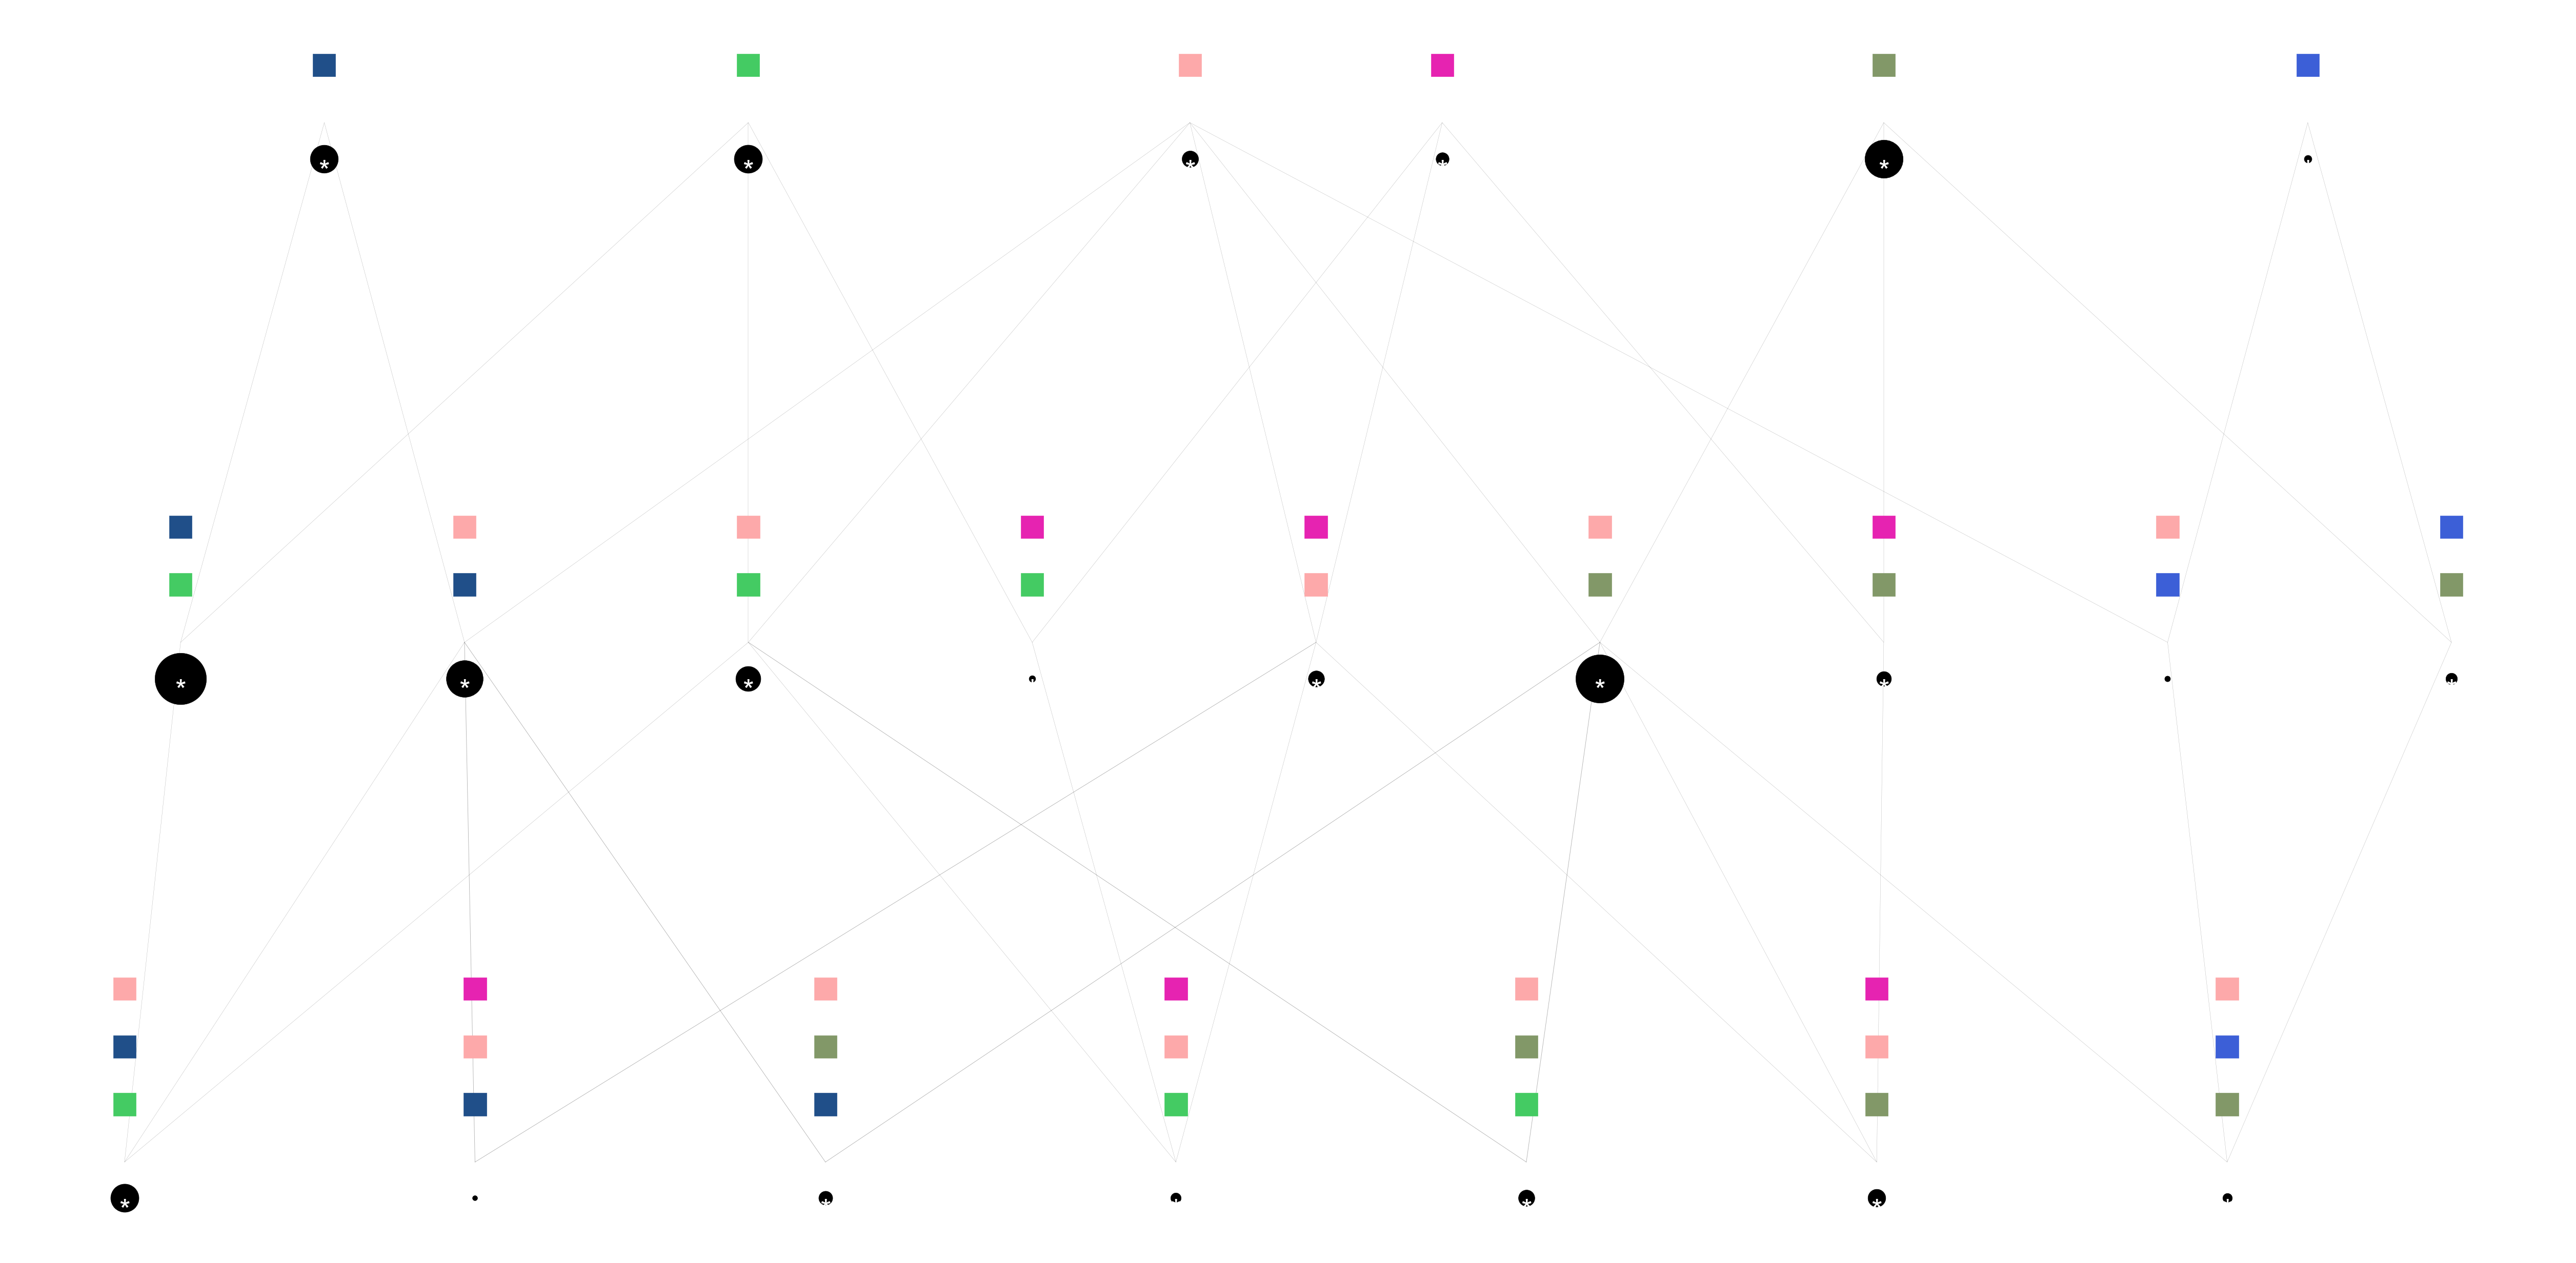

In [11]:
# Compute for the frequency of the CNs and paly around with the threshold
pl_CNmap(cnmap_dict = cnmap_dict_tonsil,
         adata = adata_tonsil,
        cn_col = "CN_k20_n6",
        palette = None,
        figsize=(40, 20),
        savefig=False,
        output_fname = "",
        output_dir= output_dir
    )

### tonsillitis

Starting: 1/1 : 0
Finishing: 1/1 : 0 0.25251197814941406 0.2525198459625244
12 0.026179659034681335


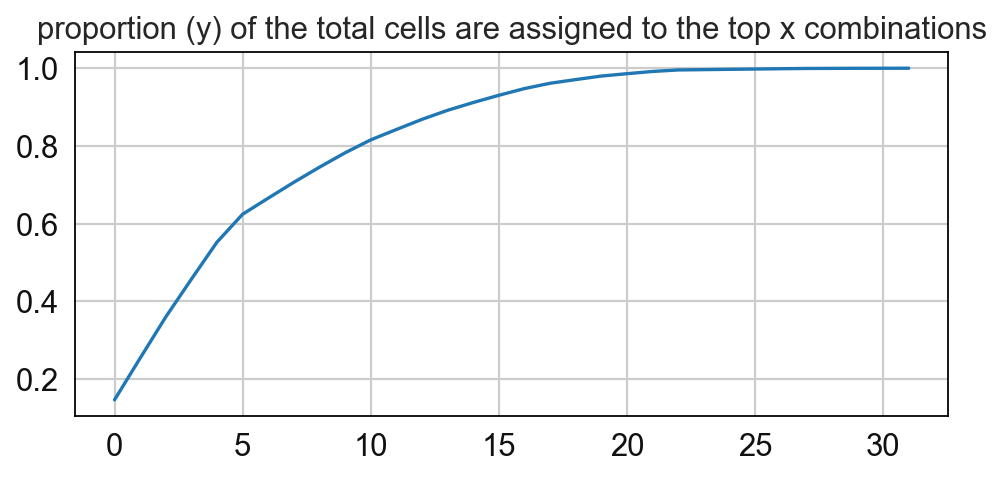

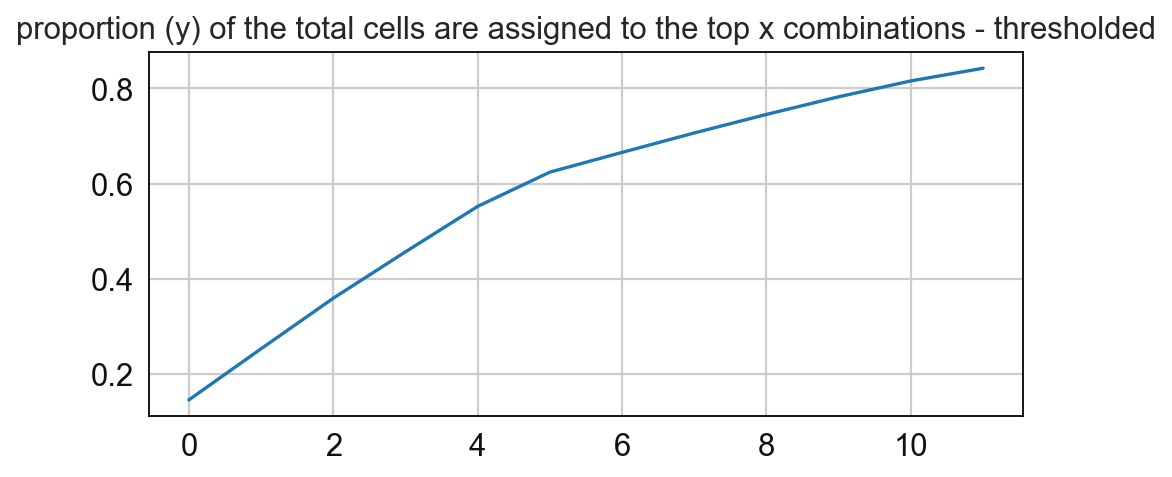

In [12]:
cnmap_dict_tonsillitis = tl_CNmap_ad(adata = adata_tonsillitis, # adata object
                                     cn_col = "CN_k20_n6",# column with CNs
                                     palette = None, # color dictionary
                                     unique_region = 'region_num',# column with unique regions
                                     k = 70, # number of neighbors
                                     X='x', Y='y',  # coordinates
                                     threshold = 0.85, # threshold for percentage of cells in CN
                                     per_keep_thres = 0.85,) # threshold for percentage of cells in CN

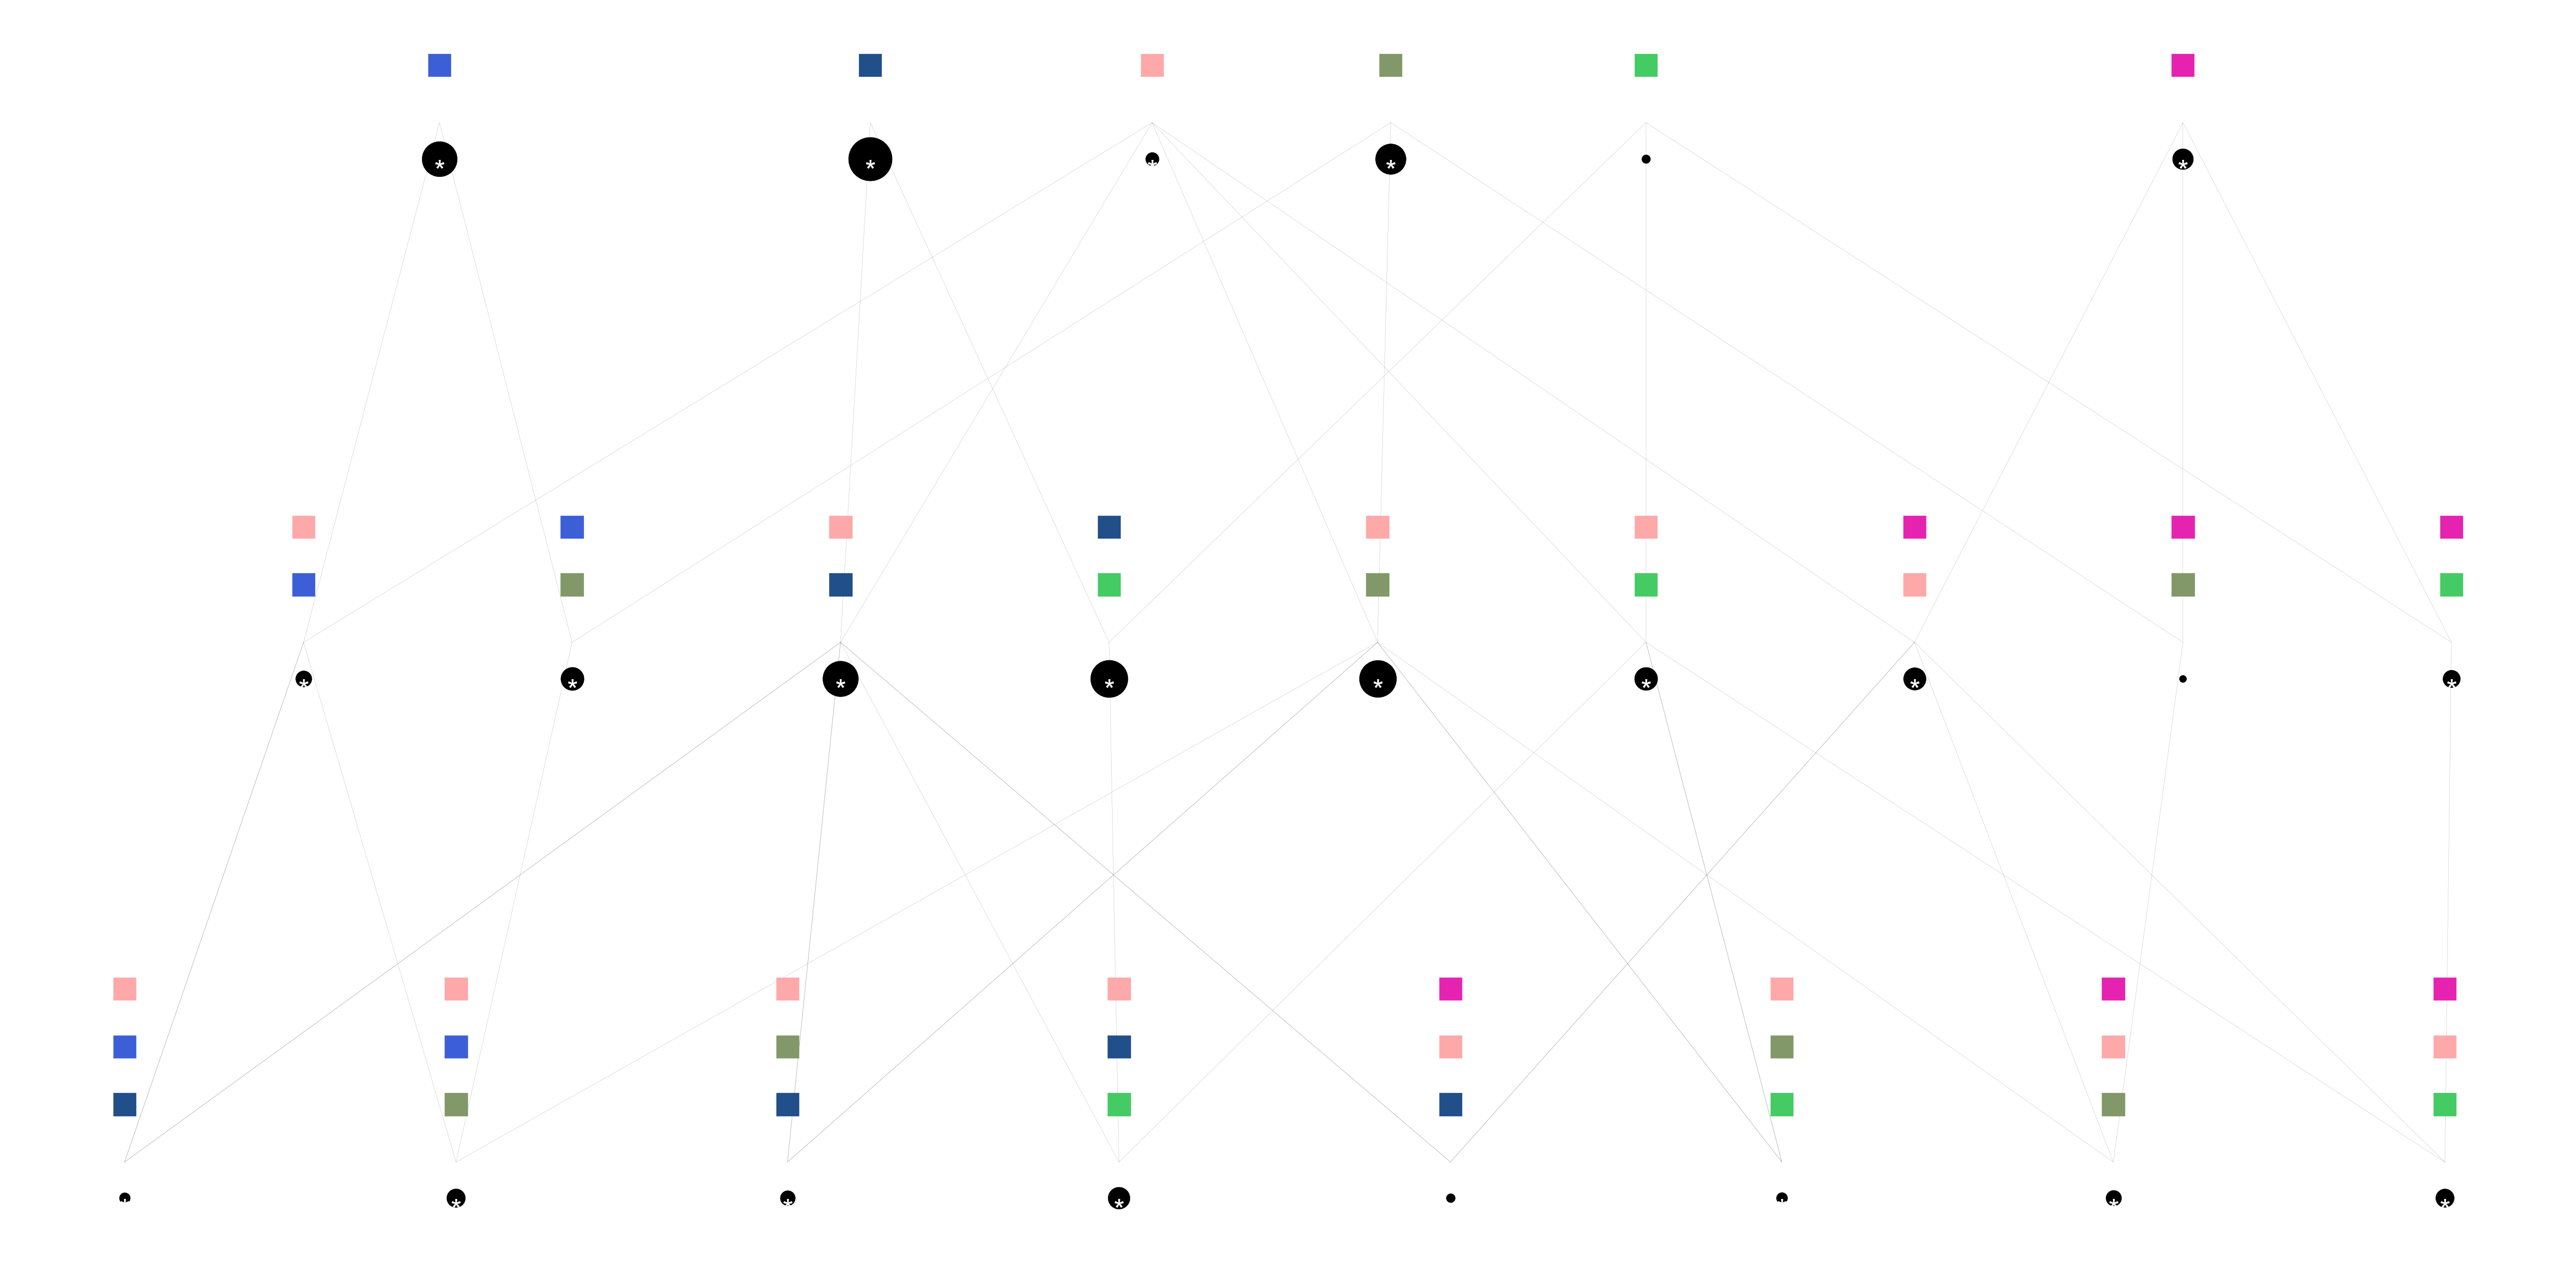

In [13]:
pl_CNmap(cnmap_dict = cnmap_dict_tonsillitis,
         adata = adata_tonsillitis,
        cn_col = "CN_k20_n6",
        palette = None,
        figsize=(40, 20),
        savefig=False,
        output_fname = "",
        output_dir= output_dir
    )